# Course Review Topic Modeling

## Exploratory Data Analysis

In [83]:
import operator, joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
from sklearn import decomposition
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# settings for our plots later
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

### Load the Data

In [84]:
waterloo=pd.read_csv("course_data_clean.csv")
waterloo.head(1)

,course_code,course_title,num_ratings,useful,easy,liked,num_reviews,reviews,course_rating,course_rating_int
0,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,go to office hours and practice,liked course,1.0


### Word Cloud

In [85]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [86]:
from wordcloud import WordCloud
import matplotlib.patches as mpatches


In [87]:
waterloo['reviews'] = waterloo['reviews'].fillna('').astype(str)


In [88]:
text = " ".join(waterloo['reviews'])

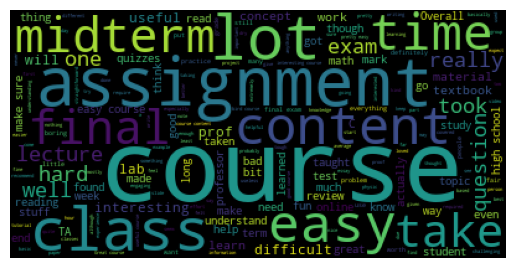

In [89]:
wordcloud2 = WordCloud().generate(text)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()


## General Topic Modeling

### Load Custom Stop Words

In [3]:
custom_stop_words = []
with open( "stopwords copy.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip())
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 363 entries


# For Positive ECON 101 reviews


In [4]:
ECON_rocks = waterloo[(waterloo['course_code'] == 'ECON 101') & (waterloo['course_rating']=='liked course')]

In [5]:
Econ_pos_reviews = ECON_rocks['reviews']
Econ_pos_reviews = Econ_pos_reviews.dropna()
Econ_pos_reviews = Econ_pos_reviews.to_list()
Econ_pos_reviews[0:3]

['Very simple',
 'Took online, almost all multiple choice, a lot of questions are common sense',
 "PROS: (1) Readings itself were simple to understand. (2) Nicely arranged content on Learn and Mobius (I took it online). (3) Decent grade, task, and submission period distribution. CONS: (1) Too many readings for a first-time learner of econ. (2) One collective zoom office hour (1 hour long) at the beginning of the week felt very unfair (3) Found a need for more OHs each week and a MS teams GC. (4) Felt isolated from the rest of the class. (5) lack of one-to-one instructional support (unless you email every question). (6) Had to refer to external resources for quicker understanding because readings were too time consuming. (7) Weren't taught at all on how to approach an article/case study. TIPS: (1) Finish all readings in the first two days of the week, (2) repeat quizzes till you get them correct (you get 4 chances per graded quiz every week, please use these well). (3) Don’t just read t

In [6]:
# use a custom stopwords list, set the minimum term-document frequency to 2
vectorizer = CountVectorizer(stop_words = custom_stop_words, min_df=2)
A = vectorizer.fit_transform(Econ_pos_reviews)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Created 98 X 151 document-term matrix


In [7]:
econ_terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(econ_terms))

Vocabulary has 151 distinct terms


In [8]:
snippets = [Econ_pos_reviews[:100] for Econ_pos_reviews in Econ_pos_reviews]
snippets[0:3]

['Very simple',
 'Took online, almost all multiple choice, a lot of questions are common sense',
 'PROS: (1) Readings itself were simple to understand. (2) Nicely arranged content on Learn and Mobius']

In [9]:
joblib.dump((A,econ_terms,snippets), "Econ-pos-reviews-raw.pkl") 

['Econ-pos-reviews-raw.pkl']

In [10]:
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 2)
A = vectorizer.fit_transform(Econ_pos_reviews)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

Created 98 X 151 TF-IDF-normalized document-term matrix


In [11]:
econ_terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(econ_terms))

Vocabulary has 151 distinct terms


In [12]:
def rank_terms(A, term):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(econ_terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

### Most common words

In [13]:
ranking = rank_terms(A, econ_terms)
for i, pair in enumerate(ranking[0:20]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1] ))

01. easy (13.60)
02. textbook (5.62)
03. concepts (3.80)
04. study (3.77)
05. good (3.75)
06. questions (3.70)
07. lectures (3.56)
08. choice (3.49)
09. multiple (3.49)
10. read (3.48)
11. economics (3.31)
12. interesting (3.29)
13. practice (3.01)
14. guide (2.99)
15. hard (2.90)
16. useful (2.82)
17. content (2.73)
18. simple (2.72)
19. boring (2.54)
20. high (2.49)


In [14]:
joblib.dump((A,econ_terms,snippets), "Econ-pos-reviews-tfidf.pkl") 

['Econ-pos-reviews-tfidf.pkl']

In [15]:
(A, econ_terms, snippets) = joblib.load("Econ-pos-reviews-tfidf.pkl")
print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 98 X 151 document-term matrix


In [16]:
k=4
# create the model, specifiying the initialization strategy and the number of topics to produce
model = decomposition.NMF(init="nndsvd", n_components=k) 
# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

In [17]:
# round to 2 decimal places for display purposes
W[0,:].round(2)

array([0.  , 0.  , 0.  , 0.17])

In [18]:
term_index = econ_terms.index('exam')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([0.  , 0.02, 0.03, 0.07])

In [19]:
def get_descriptor(econ_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index,:])[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(econ_terms[term_index])
    return top_terms

In [20]:
descriptors = []
for topic_index in range(k):
    descriptors.append(get_descriptor( econ_terms, H, topic_index, 7))
    str_descriptor = ", ".join(descriptors[topic_index])
    print("Topic %02d: %s" % (topic_index+1, str_descriptor))

Topic 01: easy, boring, light, work, fun, hard, grade
Topic 02: textbook, questions, read, study, guide, material, lectures
Topic 03: choice, multiple, online, took, exams, final, before
Topic 04: economics, concepts, high, good, school, simple, useful


Topic 01: Super Easy Class, but Boring

Topic 02: Learning tools

Topic 3: Exams

Topic 4: Course content

Note that the topic numbers are arbitrary. Topic 1 is not necessarily more prevalent than topic 2, but these should be like the top 4 topics

In [21]:
def plot_top_term_weights(econ_terms, H, topic_index, top):
    # get the top terms and their weights
    top_indices = np.argsort(H[topic_index,:])[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append(econ_terms[term_index])
        top_weights.append(H[topic_index,term_index])
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

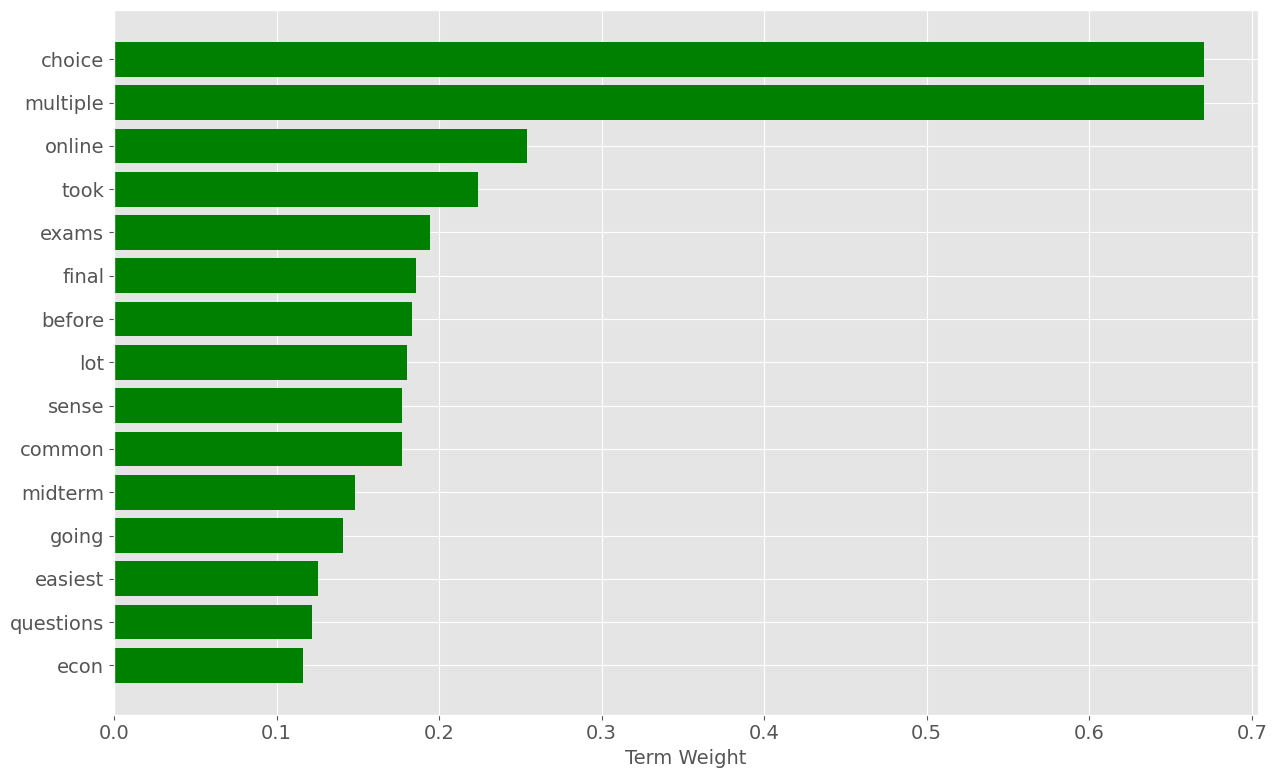

In [22]:
plot_top_term_weights(econ_terms, H, 2, 15)

In [23]:
def get_top_snippets(all_snippets, W, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append(all_snippets[doc_index])
    return top_snippets

In [24]:
topic_snippets = get_top_snippets(snippets, W, 2, 10)
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ((i+1), snippet ))

01. Easy bird course. Multiple choice ftw.
02. Took online, almost all multiple choice, a lot of questions are common sense
03. Super easy if you do it online, there was no midterm and the final was going to be all multiple choi
04. Took it as a CSE, highest graded CSE course I have on record. Multiple choice midterm and final exam
05. All multiple choice, all about memory and understanding. One of the easiest courses in first year
06. Easy course if you NEVER took econ before.. probably extremely boring if you have taken econ before.
07. I only went to 3 lectures the entire semester. Works well if you only get multiple choice exams. It'
08. Very interesting course because my prof (Packalen) was into the application of learned concepts inst
09. Read the text book, do those multiple choice questions from the study guide then you will be all set
10. Easy bird course for any student looking to fill an elective. Course goes over a lot of concepts in 


# For Positive CS 101 reviews

In [25]:
CS_rocks = waterloo[(waterloo['course_code'] == 'CS 115') & (waterloo['course_rating']=='liked course')]
CS_pos_reviews = CS_rocks['reviews']
CS_pos_reviews = CS_pos_reviews.dropna()
CS_pos_reviews = CS_pos_reviews.to_list()
CS_pos_reviews[0:5]


['go to office hours and practice',
 "Took this in 2018 with no programming experience ever. Started out pretty slow, but I didn't really pay attention and was severely behind. Went to a lot of office hours, but nonetheless caught up and did decently well. After taking more cs courses, racket really is a weird language.",
 "I loved everything about cs 115. Great instructors, fair assignments ( can get tricky but there's a huge amount of office hours to attend ), good engagement and interesting topics! It's seriously well structured and I would recommend it to anyone even with no background in coding.",
 'I recommend finding a course with a language that is actually useful. Racket is dumb and never used anywhere. The majority of the course was quite easy, except a couple of concept checks that were RIDICULOUSLY HARD. i wish i had realized sooner that you get 10% of concept checks dropped from your grade. if you understand everything and are getting most things easily but you get stumped

In [26]:
# use a custom stopwords list, set the minimum term-document frequency to 2
vectorizer = CountVectorizer(stop_words = custom_stop_words, min_df=2)
A = vectorizer.fit_transform(CS_pos_reviews)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(terms))

CS_snippets = [CS_pos_reviews[:100] for CS_pos_reviews in CS_pos_reviews]
CS_snippets[0:5]

Created 65 X 152 document-term matrix
Vocabulary has 152 distinct terms


['go to office hours and practice',
 "Took this in 2018 with no programming experience ever. Started out pretty slow, but I didn't really ",
 "I loved everything about cs 115. Great instructors, fair assignments ( can get tricky but there's a ",
 'I recommend finding a course with a language that is actually useful. Racket is dumb and never used ',
 'I really enjoyed this course online, being co-taught by 4 professors. There were lots of office hour']

In [27]:
joblib.dump((A,terms,CS_snippets), "CS-pos-reviews-raw.pkl") 

['CS-pos-reviews-raw.pkl']

In [28]:
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 2)
A = vectorizer.fit_transform(CS_pos_reviews)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(terms))

Created 65 X 152 TF-IDF-normalized document-term matrix
Vocabulary has 152 distinct terms


In [29]:
econ_terms

['100',
 '102',
 '80',
 '90',
 '90s',
 '95',
 'answer',
 'aplia',
 'application',
 'bad',
 'bank',
 'before',
 'best',
 'better',
 'boost',
 'booster',
 'boring',
 'buy',
 'case',
 'choice',
 'classes',
 'common',
 'concept',
 'concepts',
 'consuming',
 'content',
 'courses',
 'days',
 'decent',
 'definitely',
 'difficult',
 'doing',
 'easier',
 'easiest',
 'easy',
 'econ',
 'economics',
 'ended',
 'entire',
 'exam',
 'exams',
 'extremely',
 'fairly',
 'felt',
 'final',
 'finals',
 'fun',
 'going',
 'good',
 'got',
 'grade',
 'graded',
 'graphs',
 'great',
 'guaranteed',
 'guide',
 'hard',
 'help',
 'helped',
 'high',
 'hours',
 'important',
 'interesting',
 'introduction',
 'keep',
 'know',
 'kumase',
 'larry',
 'learn',
 'learning',
 'lecture',
 'lectures',
 'life',
 'light',
 'liked',
 'little',
 'long',
 'lot',
 'lots',
 'low',
 'mark',
 'marks',
 'material',
 'mc',
 'memorizing',
 'memory',
 'microeconomics',
 'mid',
 'midterm',
 'midterms',
 'multiple',
 'myeconlab',
 'notes',
 '

In [30]:
terms

['115',
 '135',
 'amount',
 'annoying',
 'aside',
 'ask',
 'assignments',
 'attend',
 'attention',
 'available',
 'background',
 'bad',
 'based',
 'basics',
 'before',
 'behind',
 'better',
 'challenge',
 'check',
 'checks',
 'coded',
 'codes',
 'coding',
 'computer',
 'concept',
 'concepts',
 'content',
 'courses',
 'covid',
 'data',
 'definitely',
 'design',
 'difficult',
 'due',
 'easiest',
 'easily',
 'easy',
 'enjoyed',
 'especially',
 'everything',
 'examples',
 'exams',
 'experience',
 'fair',
 'finding',
 'follow',
 'fun',
 'future',
 'getting',
 'good',
 'great',
 'hard',
 'help',
 'helpful',
 'hours',
 'interesting',
 'intro',
 'introduction',
 'introductory',
 'keep',
 'know',
 'labs',
 'language',
 'languages',
 'learn',
 'learned',
 'leave',
 'lectures',
 'little',
 'long',
 'lot',
 'major',
 'majority',
 'material',
 'midterm',
 'mind',
 'modules',
 'nice',
 'notes',
 'offer',
 'office',
 'okay',
 'online',
 'organized',
 'overall',
 'part',
 'pay',
 'people',
 'person',


In [31]:
def rank_terms(A, term):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [32]:
ranking = rank_terms(A, terms)
for i, pair in enumerate(ranking[0:20]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1] ))

01. easy (6.75)
02. good (4.44)
03. assignments (4.29)
04. programming (4.22)
05. racket (4.12)
06. fun (3.32)
07. time (3.17)
08. experience (2.71)
09. hours (2.36)
10. help (2.25)
11. concepts (2.24)
12. scheme (2.21)
13. interesting (2.15)
14. difficult (2.13)
15. office (2.04)
16. language (1.87)
17. questions (1.84)
18. science (1.82)
19. overall (1.81)
20. online (1.74)


In [33]:
joblib.dump((A,terms,CS_snippets), "CS-pos-reviews-tfidf.pkl") 

['CS-pos-reviews-tfidf.pkl']

In [34]:
(A, terms, CS_snippets) = joblib.load("CS-pos-reviews-tfidf.pkl")
print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 65 X 152 document-term matrix


In [35]:
k=4
# create the model, specifiying the initialization strategy and the number of topics to produce
model = decomposition.NMF(init="nndsvd", n_components=k) 
# apply the model and extract the two factor matrices
W_CS = model.fit_transform( A )
H_CS = model.components_

# round to 2 decimal places for display purposes
W_CS[0,:].round(2)



array([0.  , 0.  , 0.03, 0.25])

In [36]:
H_CS[:,term_index].round(2)

array([0.08, 0.  , 0.  , 0.08])

In [37]:
def get_descriptor(terms, H_CS, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H_CS[topic_index,:])[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
    return top_terms

In [38]:
descriptors = []
for topic_index in range(k):
    descriptors.append(get_descriptor( terms, H_CS, topic_index, 10))
    str_descriptor = ", ".join(descriptors[topic_index])
    print("Topic %02d: %s" % (topic_index+1, str_descriptor))

Topic 01: easy, assignments, interesting, relatively, material, notes, labs, keep, little, overall
Topic 02: programming, racket, good, experience, concepts, language, science, computer, introduction, useful
Topic 03: fun, codes, writing, enjoyed, scheme, overall, languages, language, lot, hard
Topic 04: time, assignments, help, online, hours, office, content, weekly, questions, tas


Topic 01: Pretty easy (Difficulty)

Topic 02: Programming

Topic 03: Fun (Enjoyability)

Topic 04: Time Management & Help

In [39]:
def plot_top_term_weights(terms, H_CS, topic_index, top):
    # get the top terms and their weights
    top_indices = np.argsort(H_CS[topic_index,:])[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
        top_weights.append(H_CS[topic_index,term_index])
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

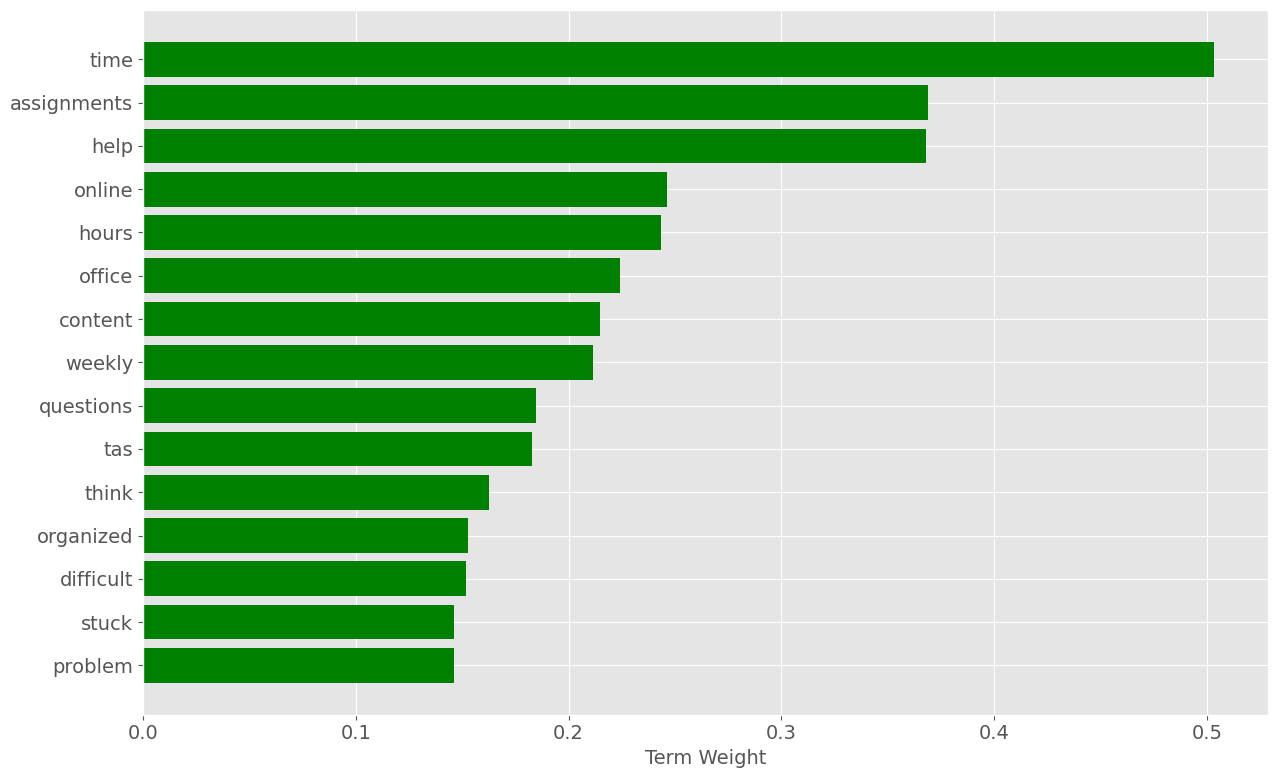

In [40]:
plot_top_term_weights(terms, H_CS, 3, 15)

In [41]:
topic_snippets = get_top_snippets(CS_pos_reviews, W_CS, 1, 10)
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ((i+1), snippet ))

01. The programming language (Scheme/Dr.Racket) wasn't a very good program to use but the concepts behind it are the same I guess ...
02. Not a bird course, although if you have background in programming it would not be difficult at all. Racket is somewhat useless but I learned some concepts that will be useful for other programming languages
03. If you feel like you have sufficient Computer Science experience, go to CS 135 because it does challenge you more. This is a good introductory course to learn programming. Also, Racket needs some getting used to.
04. I took this course online due to the COVID-19 pandemic, so my review is based on a remote, online learning experience. Overall, as someone who is not a CS student and who doesn't have a lot of background experience and knowledge in programming, it's a great introductory course to the language of Racket and the overall concepts that will be useful in later computer science courses. The Racket language itself is not a very "useful" 

# For Negative CS 101 reviews

In [42]:
CS_sucks = waterloo[(waterloo['course_code'] == 'CS 115') & (waterloo['course_rating']=='disliked course')]
CS_neg_reviews = CS_sucks['reviews']
CS_neg_reviews = CS_neg_reviews.dropna()
CS_neg_reviews = CS_neg_reviews.to_list()
CS_neg_reviews[0:5]

['One of my least favourite courses. Although things were nicely organized, Racket was such an annoying language to use. The one tangible benefit I felt after using Racket was feeling more comfortable with recursion.',
 'It starts with a very low pace but after midterm, it gets really fast and I cannot understand the content while reaching the end of term. Racket is restricted by so many things so I feel I lose the freedom of coding. The assignments are extremely hard after midterm, I spent a whole day on them but I can just solve the easiest one. The only positive impression that I have is that the design recipe weighs half so I pass this course successfully.',
 "math student who took this course since I had 0 prior programming experience. the course isn't horribly hard, but if you fall behind or don't understand one lesson, everything following will be super challenging. the course was mostly online completing modules, and my biggest criticism is that solutions for lessons are never 

In [43]:
# use a custom stopwords list, set the minimum term-document frequency to 2
vectorizer = CountVectorizer(stop_words = custom_stop_words, min_df=2)
A = vectorizer.fit_transform(CS_neg_reviews)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(terms))

CS_neg_snippets = [CS_neg_reviews[:100] for CS_neg_reviews in CS_neg_reviews]
CS_neg_snippets[0:5]

Created 18 X 55 document-term matrix
Vocabulary has 55 distinct terms


['One of my least favourite courses. Although things were nicely organized, Racket was such an annoyin',
 'It starts with a very low pace but after midterm, it gets really fast and I cannot understand the co',
 "math student who took this course since I had 0 prior programming experience. the course isn't horri",
 "This course is taught in an archaic language that no one uses and no one understands. Instructors' e",
 "It's the worst course ever, online especially. They are least interested to teach. They just provide"]

In [44]:
joblib.dump((A,terms,CS_neg_snippets), "CS-neg-reviews-raw.pkl") 

['CS-neg-reviews-raw.pkl']

In [45]:
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 2)
A = vectorizer.fit_transform(CS_neg_reviews)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(terms))

Created 18 X 55 TF-IDF-normalized document-term matrix
Vocabulary has 55 distinct terms


In [46]:
ranking = rank_terms(A, terms)
for i, pair in enumerate(ranking[0:20]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1] ))

01. easy (2.19)
02. racket (1.57)
03. online (1.41)
04. midterm (1.37)
05. language (1.32)
06. hate (1.25)
07. difficult (1.18)
08. coding (1.03)
09. hard (0.95)
10. design (0.94)
11. took (0.93)
12. assignment (0.90)
13. lot (0.89)
14. marks (0.89)
15. assignments (0.89)
16. way (0.82)
17. courses (0.81)
18. teach (0.79)
19. learn (0.77)
20. recursion (0.77)


In [47]:
joblib.dump((A,terms,CS_neg_snippets), "CS-neg-reviews-tfidf.pkl") 

['CS-neg-reviews-tfidf.pkl']

In [48]:
(A, terms, CS_neg_snippets) = joblib.load("CS-neg-reviews-tfidf.pkl")
print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 18 X 55 document-term matrix


In [49]:
k=4
# create the model, specifiying the initialization strategy and the number of topics to produce
model = decomposition.NMF(init="nndsvd", n_components=k) 
# apply the model and extract the two factor matrices
W_CS = model.fit_transform( A )
H_CS = model.components_

# round to 2 decimal places for display purposes
W_CS[0,:].round(2)

array([0.06, 0.  , 0.43, 0.17])

In [50]:
def get_descriptor(terms, H_CS, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H_CS[topic_index,:])[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
    return top_terms

In [51]:
descriptors = []
for topic_index in range(k):
    descriptors.append(get_descriptor( terms, H_CS, topic_index, 10))
    str_descriptor = ", ".join(descriptors[topic_index])
    print("Topic %02d: %s" % (topic_index+1, str_descriptor))

Topic 01: easy, coding, useful, math, friend, able, organized, code, lot, courses
Topic 02: midterm, assignments, coding, hard, exam, something, way, day, solve, write
Topic 03: hate, racket, marks, lose, recipe, design, recursion, things, felt, organized
Topic 04: online, language, worst, experience, prior, programming, took, difficult, teach, assignment


Topic 1: General difficulty level (some felt hard, some easy, but disliked)

Topic 2: Midterm and assignments difficulty

Topic 3: Hating racket (programming language)

Topic 4: Poor online experience

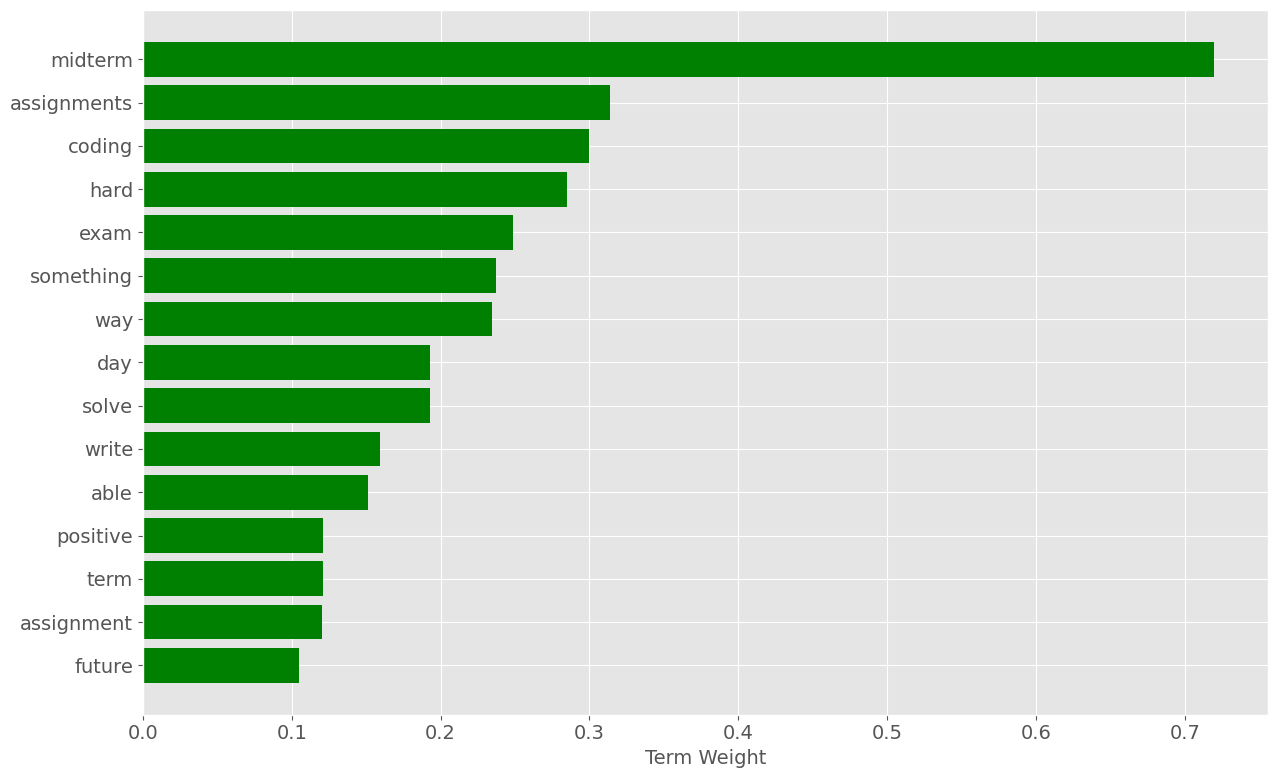

In [52]:
plot_top_term_weights(terms, H_CS, 1, 15)

In [53]:
topic_snippets = get_top_snippets(CS_neg_reviews, W_CS, 1, 10)
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ((i+1), snippet ))

01. It's hard to motivate yourself to do the assignments when each is 2% or something, but it really is important to keep on top of it. They only get harder and arguably the only way to guarantee that you'll do well on the midterm (since you WILL be asked to write mini programs) I personally found the exam to be much harder than the midterm, so you really need to use the midterm as a grade booster.
02. It starts with a very low pace but after midterm, it gets really fast and I cannot understand the content while reaching the end of term. Racket is restricted by so many things so I feel I lose the freedom of coding. The assignments are extremely hard after midterm, I spent a whole day on them but I can just solve the easiest one. The only positive impression that I have is that the design recipe weighs half so I pass this course successfully.
03. Not an "EASY" course at all. Anyone commentating that is probably a Math/Eng student who is already familiar with coding through other courses

## Cosine Similarity Between Topics

In [54]:
print(W.shape, W_CS.shape)


(98, 4) (18, 4)


In [55]:
print(H.shape, H_CS.shape)


(4, 151) (4, 55)


In [56]:
terms_set = set(terms)  # Terms corresponding to H_W
econ_terms_set = set(econ_terms)  # Terms corresponding to H_W_CS

common_terms = terms_set.intersection(econ_terms_set)

common_terms

{'before',
 'content',
 'courses',
 'difficult',
 'easy',
 'exam',
 'felt',
 'hard',
 'learn',
 'lot',
 'marks',
 'midterm',
 'online',
 'prior',
 'questions',
 'student',
 'took',
 'understand',
 'useful',
 'way'}

In [57]:
import numpy as np
np.set_printoptions(threshold=np.inf)

In [58]:
from sklearn.metrics.pairwise import cosine_similarity

np.round(cosine_similarity(H,H_CS),2).shape


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 151 while Y.shape[1] == 55

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize

# Assume W1 and W2 are your NMF topic-term matrices (shape: 10 topics x vocabulary size)
# Example W1 and W2 (replace with your actual data):
# W1 = nmf_model_1.components_ (from course 1 NMF model)
# W2 = nmf_model_2.components_ (from course 2 NMF model)

# Normalize the topic vectors by their L2 norms
H_normalized = normalize(H.T, axis=1)  # Normalizing each row vector (topic)
H_CS_normalized = normalize(H_CS.T, axis=1)

# Initialize the similarity matrix
similarity_matrix = np.zeros((H_normalized.shape[0], H_CS_normalized.shape[0]))

# Compute the cosine similarity between each pair of topics
for i in range(H_normalized.shape[0]):
    for j in range(H_CS_normalized.shape[0]):
        similarity_matrix[i, j] = np.dot(H_normalized[i], H_CS_normalized[j])

# Print or return the similarity matrix
print(similarity_matrix)

# Plotting the similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cosine Similarity')
plt.title('Topic Similarity Matrix (Course 1 vs Course 2)')
plt.xlabel('Course 2 Topics')
plt.ylabel('Course 1 Topics')
plt.xticks(ticks=np.arange(10), labels=[f'Topic {i+1}' for i in range(10)])
plt.yticks(ticks=np.arange(10), labels=[f'Topic {i+1}' for i in range(10)])
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize

# Transpose the matrices so that topics are rows and terms are columns
W_normalized = normalize(W.T, axis=1)  # Now (10 topics, 98 terms)
W_CS_normalized = normalize(W_CS.T, axis=1)  # Now (10 topics, 65 terms)

# Compute the cosine similarity
similarity_matrix = np.zeros((W_normalized.shape[0], W_CS_normalized.shape[0]))

for i in range(W_normalized.shape[0]):
    for j in range(W_CS_normalized.shape[0]):
        similarity_matrix[i, j] = np.dot(W_normalized[i], W_CS_normalized[j])

# Plotting the similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title('Topic Similarity Matrix (Course 1 vs Course 2)')
plt.xlabel('Course 2 Topics')
plt.ylabel('Course 1 Topics')
plt.xticks(ticks=np.arange(10), labels=[f'Topic {i+1}' for i in range(10)])
plt.yticks(ticks=np.arange(10), labels=[f'Topic {i+1}' for i in range(10)])
plt.show()
